In [83]:
import pandas as pd
import os
import torch
import json
import numpy as np

In [84]:
%run ../Config.ipynb

In [85]:
config = Config()

#### Rmsd's 

In [86]:
file_name_rmsd = 'rmsd'
#file_name_rmsd = "rmsd_refined_set"

In [87]:
rmsd = pd.read_csv(f"{config.data}/{file_name_rmsd}.csv").sort_values(['pdb','poserank','RMSD']).drop_duplicates(['pdb','poserank'], keep = 'first')

sup = rmsd.groupby('pdb')[['poserank']].count().reset_index().rename(columns = {"poserank":"poserank_count"})
sup['unique_pdb_count'] = sup.groupby('poserank_count')['pdb'].transform('nunique')
sup.drop(columns = ['pdb']).drop_duplicates().sort_values('poserank_count')

,poserank_count,unique_pdb_count
4,1,7
111,2,3
58,3,4
42,4,3
128,5,6
92,6,6
28,7,5
9,8,5
7,9,51
0,10,190


In [88]:
rmsd['pdb'].nunique()

280

Obs: There is one pdb missing!

In [89]:
rmsd[rmsd['pdb'] == "4kz6"]['poserank'].value_counts()

2     1
3     1
5     1
6     1
8     1
9     1
10    1
Name: poserank, dtype: int64

In [90]:
rmsd[rmsd['pdb'] =='185l'].sort_values('poserank')

,pdb,poserank,RMSD


In [91]:
sup = rmsd.groupby('pdb')[['poserank']].count().reset_index().rename(columns = {"poserank":"poserank_count"})
sup['unique_pdb_count'] = sup.groupby('poserank_count')['pdb'].transform('nunique')
sup.drop(columns = ['pdb']).drop_duplicates().sort_values('poserank_count')

,poserank_count,unique_pdb_count
4,1,7
111,2,3
58,3,4
42,4,3
128,5,6
92,6,6
28,7,5
9,8,5
7,9,51
0,10,190


In [92]:
sup[sup['poserank_count']==10]['pdb'].nunique()

190

In [93]:
sup[sup['poserank_count']==9]['pdb'].nunique()

51

In [94]:
sup[sup['poserank_count']==8]['pdb'].nunique()

5

In [95]:
sup[sup['poserank_count']==7]['pdb'].nunique()

5

In [96]:
sup[sup['poserank_count']==6]['pdb'].nunique()

6

In [97]:
sup[sup['poserank_count']==5]['pdb'].nunique()

6

In [98]:
import seaborn as sns

In [99]:
rmsd.head()

,pdb,poserank,RMSD
577,1a30,1,5.40
578,1a30,2,9.04
579,1a30,3,6.84
580,1a30,4,7.84
581,1a30,5,6.18


In [100]:
len(rmsd)

2537

In [101]:
#sns.boxplot(rmsd.pivot_table(index = 'pdb', columns = 'poserank', values = 'RMSD'), color='steelblue')

sns.boxplot(data=rmsd, x='poserank', y='RMSD', color='steelblue')
plt.xlabel('Pose Ranking')
plt.ylabel('Root Mean Square Deviation (RMSD)')
plt.title('Distribuição do RMSD pelo ranking da pose')

# Remove apenas os eixos superior e direito
sns.despine(top=True, right=True)

# Desativa a grade
plt.grid(False)

plt.show()


#### Creating label 

In [102]:
label = rmsd.copy()

#### Score similarity 

In [103]:
score = pd.read_json(f"{config.data}/score.json").unstack().reset_index().rename(columns = {"level_0":"pdb", "level_1":"poserank", 0:'similarity'})

In [104]:
score.head()

,pdb,poserank,similarity
0,4eor,1,16.666667
1,4eor,2,72.916667
2,4eor,3,8.333333
3,4eor,4,7.291667
4,4eor,5,18.750000


#### Merge

In [105]:
label = pd.merge(score, label, left_on= ['pdb','poserank'], right_on = ['pdb','poserank'], how = 'outer').drop_duplicates()

In [106]:
label.head()

,pdb,poserank,similarity,RMSD
0,4eor,1,16.666667,4.34
1,4eor,2,72.916667,1.16
2,4eor,3,8.333333,4.94
3,4eor,4,7.291667,4.92
4,4eor,5,18.750000,6.54


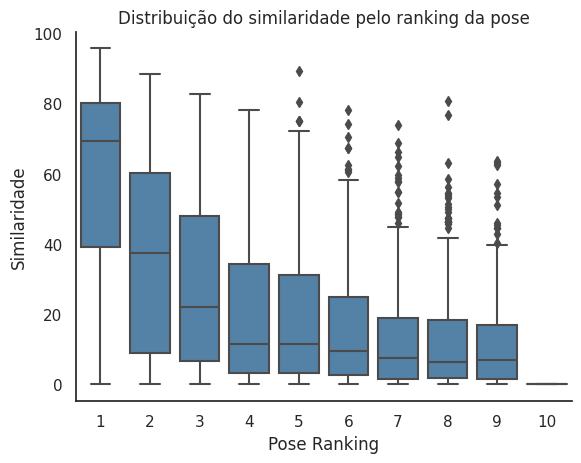

In [107]:
sns.boxplot(data=label, x='poserank', y='similarity', color='steelblue')
plt.xlabel('Pose Ranking')
plt.ylabel('Similaridade')
plt.title('Distribuição do similaridade pelo ranking da pose')

# Remove apenas os eixos superior e direito
sns.despine(top=True, right=True)

# Desativa a grade
plt.grid(False)

plt.show()

In [108]:
#label.sort_values('similarity', ascending = False).tail(30)

| score | rmsd |
|-------|------|
| rmsd < 2 | -10 |
| 2 < rmsd < 3 | -7 |
| rmsd > 3 | 0 |

| score | match |
|-------|-------|
| 79 | -10 |
| 70 | -7 |
| 66 | 0 |
| 42 | 0 |


#### Conditions

In [109]:
# Define the conditions and corresponding scores
conditions_rmsd = [ label['RMSD'] < 2
              ,(label['RMSD'] >= 2) & (label['RMSD'] < 3)
              , label['RMSD'] >= 3]

In [110]:
conditions_similarity = [ label['similarity'] >=80 
              ,(label['similarity'] >= 70) & (label['similarity'] < 80)
              #,(label['similarity'] >= 66) & (label['similarity'] < 70)
              , label['similarity'] < 70 ]

In [111]:
scores_rmsd       = [10, 7, 0]
scores_similarity = [10, 7, 0]

label['rmsd_weight'] = np.select(conditions_rmsd, scores_rmsd, default=np.nan)
label['similarity_weight'] = np.select(conditions_similarity, scores_similarity, default=np.nan)

#### Métrica 

$$
\frac{{\text{{score\_rmsd}} \times 0.5 + \text{{score\_match}} \times 0.5}}{{20}}
$$


In [112]:
label['weight'] = (label['rmsd_weight']*0.5 + label['similarity_weight']*0.5)/10
label['weight_similarity'] = (label['rmsd_weight']*0.3 + label['similarity_weight']*0.7)/10
label['weight_rmsd'] = (label['rmsd_weight']*0.7 + label['similarity_weight']*0.3)/10

In [113]:
label['weight'].value_counts()

0.00    1765
0.35     313
0.50     263
1.00      92
0.85      91
0.70      13
Name: weight, dtype: int64

In [114]:
label["label"] = label["weight"].apply(lambda x: 1 if x > 0.5 else 0)

In [115]:
label.head()

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,weight_similarity,weight_rmsd,label
0,4eor,1,16.666667,4.34,0.0,0.0,0.00,0.00,0.00,0
1,4eor,2,72.916667,1.16,10.0,7.0,0.85,0.79,0.91,1
2,4eor,3,8.333333,4.94,0.0,0.0,0.00,0.00,0.00,0
3,4eor,4,7.291667,4.92,0.0,0.0,0.00,0.00,0.00,0
4,4eor,5,18.750000,6.54,0.0,0.0,0.00,0.00,0.00,0


In [116]:
label.to_csv('../Datahub/label_dataframe.csv')

In [117]:
label['label'].value_counts()

0    2644
1     196
Name: label, dtype: int64

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_density(x, label, xlabel):
    """
    Plots density plots for each class in the given data.

    Parameters:
    x (str): The column name for the data to be plotted.
    label (DataFrame): A DataFrame containing the data and labels.
    xlabel (str): The label for the x-axis.
    """
    # Set the style for the plot
    sns.set(style="white")

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Remove the grid
    ax.grid(False)

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot density plots for each class with increased transparency
    sns.kdeplot(data=label[label['label'] == 0], x=x, fill=True, color='darkred', alpha=0.3, ax=ax, label='Incorreto')
    sns.kdeplot(data=label[label['label'] == 1], x=x, fill=True, color='steelblue', alpha=0.3, ax=ax, label='Correto')

    # Show the legend without the frame
    ax.legend(frameon=False)

    # Set the x-axis label
    ax.set_xlabel(xlabel)

    # Display the plot
    plt.show()


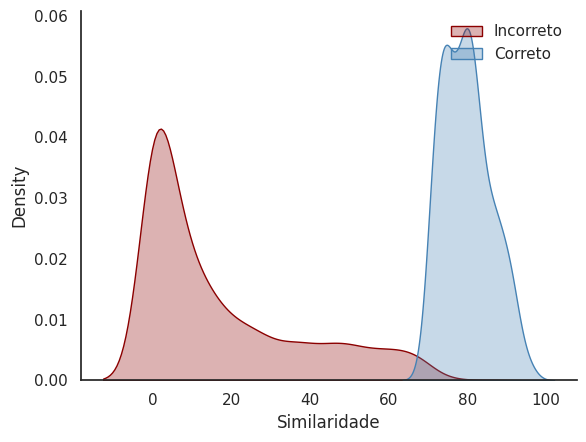

In [119]:
plot_density('similarity', label, 'Similaridade')

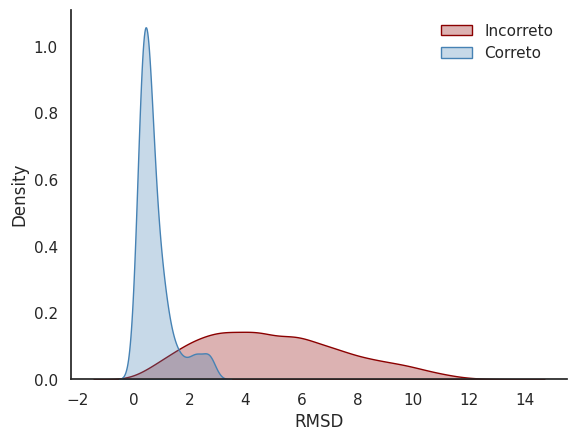

In [120]:
plot_density('RMSD', label, 'RMSD')

#### Stats

In [121]:
len(label['label'])

2840

In [122]:
label['pdb'].nunique()

284

In [123]:
label['label'].value_counts(1)

0    0.930986
1    0.069014
Name: label, dtype: float64

In [124]:
label.head()

,pdb,poserank,similarity,RMSD,rmsd_weight,similarity_weight,weight,weight_similarity,weight_rmsd,label
0,4eor,1,16.666667,4.34,0.0,0.0,0.00,0.00,0.00,0
1,4eor,2,72.916667,1.16,10.0,7.0,0.85,0.79,0.91,1
2,4eor,3,8.333333,4.94,0.0,0.0,0.00,0.00,0.00,0
3,4eor,4,7.291667,4.92,0.0,0.0,0.00,0.00,0.00,0
4,4eor,5,18.750000,6.54,0.0,0.0,0.00,0.00,0.00,0


#### Creating dict 

In [125]:
# Create the nested dictionary
result_dict = {}
for index, row in label.iterrows():
    pdb = row['pdb']
    poserank = row['poserank']
    label = row['label']
    
    if pdb not in result_dict:
        result_dict[pdb] = {}
    
    result_dict[pdb][poserank] = label

In [126]:
#print("label.json saved at:", config.data)

In [127]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "w") as json_file:
    json.dump(result_dict, json_file)

In [128]:
# Assuming result_dict is your dictionary
with open(f"{config.data}/label.json", "r") as json_file:
    result = json_file.read()

In [129]:
result = pd.read_json(f"{config.data}/label.json")

In [130]:
result

,4eor,2qbq,3g2n,1ydr,3uev,2xnb,3qqs,1w4o,4jxs,3zsx,...,4ddh,3oe4,3g31,4jsz,3udh,4w9l,2cbv,4j28,2j78,3bgz
1,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,1,0
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Report 

#### Merge 

In [131]:
path_to_docked = "/home/lbcb02/Workspace/General data/docked/ex_50_bz_10_poses_10_v2"
lepton = pd.DataFrame(columns = ["pdb","class"])

for class_ in ["best","good","bad","verybad"]: 
    color_path = os.path.join(path_to_docked, class_)
    if os.path.exists(color_path):
        for pdb in os.listdir(color_path):
            lepton = lepton.append({"pdb":pdb, "class":class_}, ignore_index = True)
    else:
        print("Incorrect path")

In [132]:
mapeador = {'best': 'A'
            , 'good': 'B'
            , 'bad': 'C'
            , 'verybad': 'D'}

In [133]:
lepton['class_to_sort'] = lepton['class'].map(mapeador)

In [136]:
label.head()

AttributeError: 'int' object has no attribute 'head'

In [134]:
label = label.round(2)

AttributeError: 'int' object has no attribute 'round'

In [79]:
label.head()

In [80]:
best_weight = label.sort_values(["pdb", "weight"], ascending = False).drop_duplicates("pdb", keep = "first")
best_weight_similarity = label.sort_values(["pdb", "weight_similarity"], ascending = False).drop_duplicates("pdb", keep = "first")
best_weight_rmsd = label.sort_values(["pdb", "weight_rmsd"], ascending = False).drop_duplicates("pdb", keep = "first")

AttributeError: 'int' object has no attribute 'sort_values'

In [ ]:
#label.sort_values(["pdb", "weight"], ascending = False).head(30)

In [ ]:
merged_best_weight = pd.merge(best_weight, lepton, on = ['pdb'], how = "inner")
merged_best_weight_similarity = pd.merge(best_weight_similarity, lepton, on = ['pdb'], how = "inner")
merged_best_weight_rmsd = pd.merge(best_weight_rmsd, lepton, on = ['pdb'], how = "inner")

#### Functions 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_count_distribution(data, x, hue, title):
    # Set the style for the plot
    sns.set(style="whitegrid")

    # Create a figure and axis
    fig, ax = plt.subplots()


    # Remove the grid
    ax.grid(False)

    # Remove the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Plot a bar plot with hue for each class
    sns.countplot(data=data, x=x, hue=hue, palette='tab10')

    # Set the plot labels and title
    ax.set(xlabel='Classe', ylabel='Qtd', title=title)

    # Format x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')

    # Display the plot
    plt.show()

#### Distribuition 

In [ ]:
plot_count_distribution(data=merged_best_weight.sort_values('class_to_sort'), x='weight', hue='class', title = 'Distribuição para rmsd e similaridade com pesos iguais')

In [ ]:
plot_count_distribution(data=merged_best_weight_similarity.sort_values('class_to_sort'), x='weight_similarity', hue='class', title = 'Distribuição para similaridade com peso maior')

In [ ]:
plot_count_distribution(data=merged_best_weight_rmsd.sort_values('class_to_sort'), x='weight_rmsd', hue='class',  title = 'Distribuição para RMSD com peso maior')

In [ ]:
#merged_best[(merged_best['class']=='best') & (merged_best['weight']==0.5)].head(10)

First the RMSD and the similarity metric is caulculated, 

| score | rmsd weight |
|-------|------|
| rmsd < 2 | 10 |
| 2 < rmsd < 3 | 7 |
| rmsd > 3 | 0 |

| score | match weight|
|-------|-------|
| > 80 | 10 |
| >= 70 | 7 |
| < 70 | 0| 


Then the score is thefined as 

$$
Score = \frac{{\text{{rmsd weight}} \times 0.3 + \text{{match weight}} \times 0.7}}{{20}}
$$

